In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,BatchNormalization,GRU
from tensorflow import keras,ones_like,zeros_like
from tensorflow.keras import layers
import tensorflow as tf


In [2]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\saved_data.csv")

In [3]:
time=data['Date']
data=data.drop('Date', axis=1)
target="BTC_close"


In [4]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
0,0.1,0.1,0.1,0.1,0.26,936.0,182.0,1090.745856,789700.0,0.000000,...,0.0,0.0,0.0,0.0,1191.7,17.693,0.00,1083.48,10229.96,9300.46
1,0.1,0.1,0.1,0.1,0.58,784.0,182.0,603.821256,499964.0,0.000000,...,0.0,0.0,0.0,0.0,1191.8,17.803,0.00,1069.59,10120.53,9278.83
2,0.1,0.1,0.1,0.1,2.16,594.0,182.0,572.443182,403000.0,0.000000,...,0.0,0.0,0.0,0.0,1195.6,18.120,7002.75,1093.67,10322.30,9220.88
3,0.1,0.1,0.1,0.1,2.40,655.0,182.0,530.932990,412004.0,0.000606,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96
4,0.1,0.1,0.1,0.1,0.50,959.0,182.0,1519.539683,1148772.0,0.000000,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96


In [5]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [6]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [7]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [8]:
time_step=40
train_time_line=[]
val_time_line=[]
test_time_line=[]

In [9]:
def scale_sequence_data(df,timesteps ,close_col_idx):
    x = []
    y = []
    timeLine=[]
    for i in range(len(df)-timesteps):    
        scaler=MinMaxScaler()      
        scaler.fit(df[i:i+timesteps,:])
        timeLine.append((scaler.data_min_[close_col_idx],scaler.data_max_[close_col_idx]))
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y),timeLine


In [10]:
train_x, train_y,train_time_line = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'))
val_x,val_y,val_time_line =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'))
test_x, test_y,test_time_line = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'))

In [29]:
class Generator(Model):
    def __init__(self,):
        super().__init__()

        self.LSTM1 = LSTM(64, return_sequences=True, recurrent_dropout=0.3)
        self.LSTM2 = LSTM(64, return_sequences=True, recurrent_dropout=0.3)
        self.LSTM3 = LSTM(64, return_sequences=False, recurrent_dropout=0.3)
        self.batch_norm = BatchNormalization()
        
        self.dense = Dense(16, activation='relu')
        
        self.out = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x1 = self.LSTM1(inputs)
        x1 = self.batch_norm(x1)
        x2 = self.LSTM2(x1)
        x2 = self.batch_norm(x2)
        x3 = self.LSTM3(x2)
        x4 = self.dense(x3)
        return self.out(x4)
        
generator = Generator()

In [30]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.Dense1 = Dense(128, activation=layers.LeakyReLU(alpha=0.01))
        self.Dense2 = Dense(64, activation=layers.LeakyReLU(alpha=0.01))
        self.Dense3 = Dense(64, activation=layers.LeakyReLU(alpha=0.01))
        self.Dense4 = Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x1 = self.Dense1(inputs) 
        x2 = self.Dense2(x1)
        x3 = self.Dense3(x2)
        return self.Dense4(x3)
        
discriminator = Discriminator()


In [92]:
mse = keras.losses.MeanSquaredError()
mae = keras.losses.MeanAbsoluteError()

In [93]:
adam = keras.optimizers.legacy.Adam(
    learning_rate=0.0002
)
generator_optimizer = adam
discriminator_optimizer = adam

In [94]:
def discriminator_loss(real_output, fake_output):
    real_loss = mse(ones_like(real_output), real_output)
    fake_loss = mse(zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return 3*mae(train_y.reshape((-1,1)),generator(train_x)) + mse(ones_like(fake_output), fake_output)

In [95]:
def train_step(real_x,real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data=generator(real_x,training=True) # [price1,price2,...]
        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    print("Generator loss %s | Discriminator loss %s" %(float(gen_loss), float(disc_loss)))
    print("Val loss evaluation", generator.evaluate(val_x,val_y))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_y, generated_data, disc_loss,gen_loss


**Train**

In [96]:
generator.compile(loss="MeanSquaredError")
epochs=10
batch_size=512
list_d_loss=[]
list_g_loss=[]
for i in range(epochs):
    print("*i =", i, ":")
    for j in range(0,train_x.shape[0]-batch_size-1,batch_size):
        print("*i =", i, "and j =", j, ":")
        real_x=train_x[j:batch_size+j]
        real_y=train_y[j:batch_size+j]
        real_y, generated_data,d_loss,g_loss=train_step(real_x,real_y)
        list_d_loss.append(d_loss)
        list_g_loss.append(g_loss)
        

*i = 0 :
*i = 0 and j = 0 :
Generator loss 0.7838157415390015 | Discriminator loss 0.49213001132011414
21/21 [==============================] - 3s 45ms/step - loss: 0.0627
Val loss evaluation 0.06265345960855484
*i = 0 and j = 512 :
Generator loss 0.7468964457511902 | Discriminator loss 0.5082010626792908
21/21 [==============================] - 1s 30ms/step - loss: 0.0564
Val loss evaluation 0.056447844952344894
*i = 0 and j = 1024 :
Generator loss 0.7559232711791992 | Discriminator loss 0.5016508102416992
21/21 [==============================] - 1s 39ms/step - loss: 0.0588
Val loss evaluation 0.05875362083315849
*i = 0 and j = 1536 :
Generator loss 0.7514432668685913 | Discriminator loss 0.5002337694168091
21/21 [==============================] - 1s 36ms/step - loss: 0.0577
Val loss evaluation 0.05769661068916321
*i = 0 and j = 2048 :
Generator loss 0.7407647371292114 | Discriminator loss 0.5069323778152466
21/21 [==============================] - 1s 29ms/step - loss: 0.0550
Val loss

In [97]:
generator.evaluate(test_x,test_y)

21/21 [==============================] - 0s 22ms/step - loss: 0.0417


0.041664935648441315

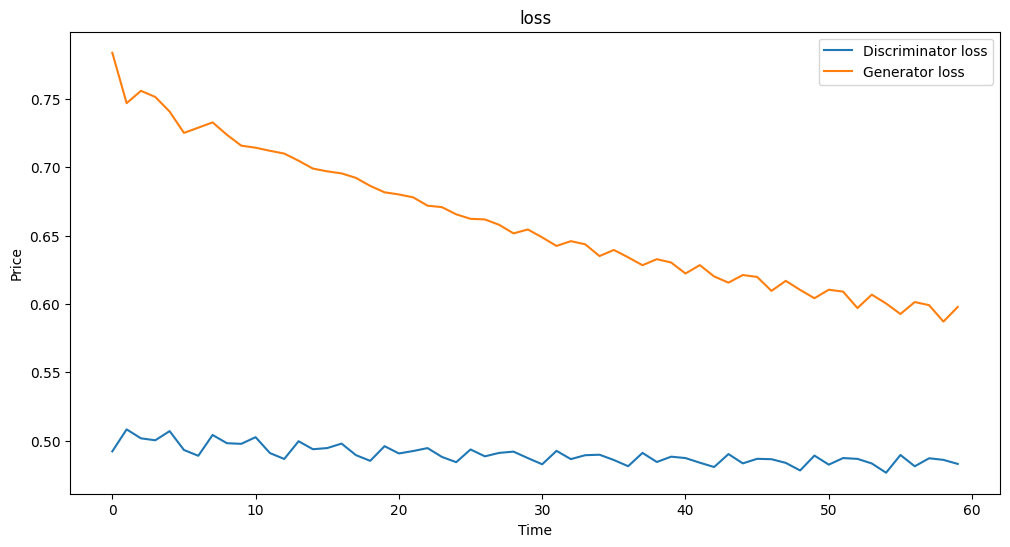

In [98]:
plt.figure(figsize=(12,6))
plt.plot(list_d_loss, label='Discriminator loss')
plt.plot(list_g_loss, label='Generator loss')

plt.title('loss')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [99]:
prediction = generator.predict(test_x)
train_pred=generator.predict(train_x)

101/101 [==============================] - 2s 20ms/step


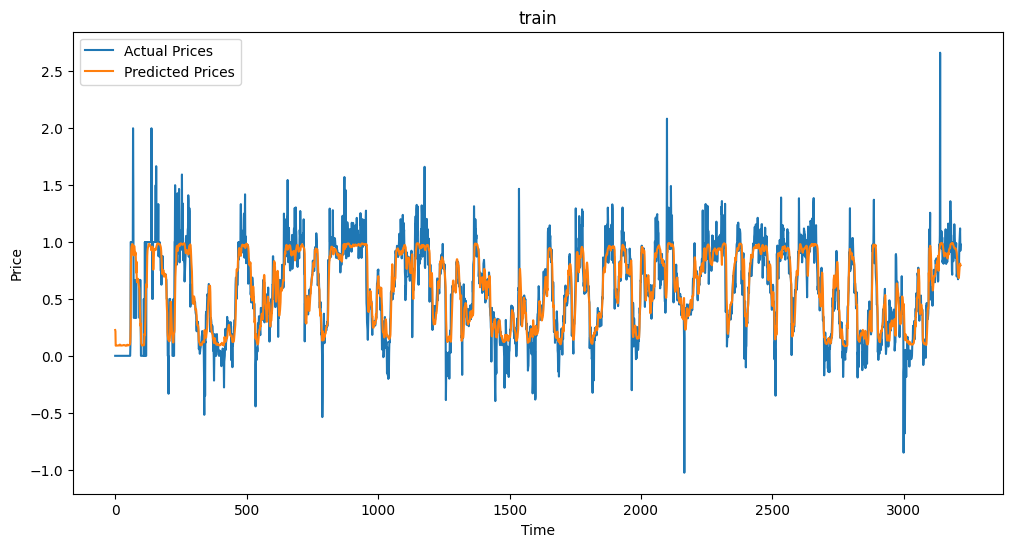

In [100]:
plt.figure(figsize=(12,6))
plt.plot(train_y, label='Actual Prices')
plt.plot(train_pred, label='Predicted Prices')

plt.title('train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

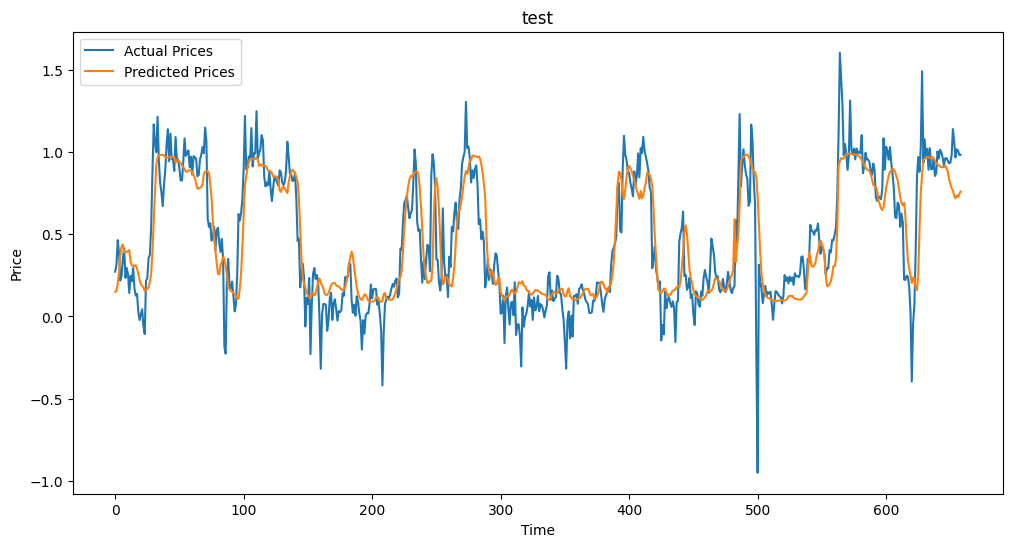

In [101]:
plt.figure(figsize=(12,6))
plt.plot(test_y, label='Actual Prices')
plt.plot(prediction, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [102]:
def inverseTransform(value, timeline):
    result = []
    for i in range(len(timeline)):
        min_val = timeline[i][0]
        max_val = timeline[i][1]
        original_value = (value[i] * (max_val - min_val)) + min_val
        result.append(original_value)
    return np.array(result)


In [103]:
pred_after_inverse=inverseTransform(prediction,test_time_line)
true_after_inverse=inverseTransform(test_y,test_time_line)
inverse_train_pred=inverseTransform(train_pred,train_time_line)
inverse_train_true=inverseTransform(train_y,train_time_line)

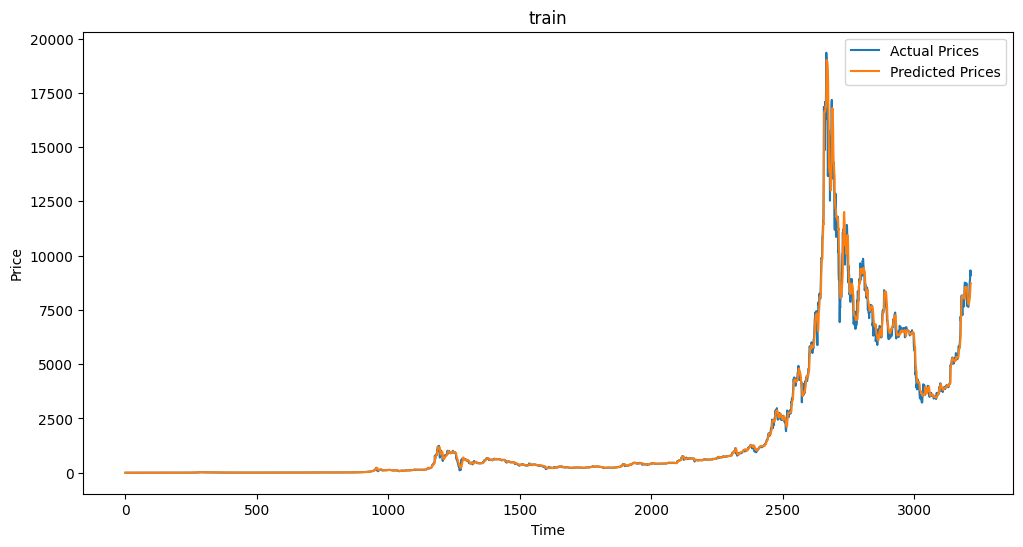

In [104]:
plt.figure(figsize=(12,6))
plt.plot(inverse_train_true, label='Actual Prices')
plt.plot(inverse_train_pred, label='Predicted Prices')

plt.title('train')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

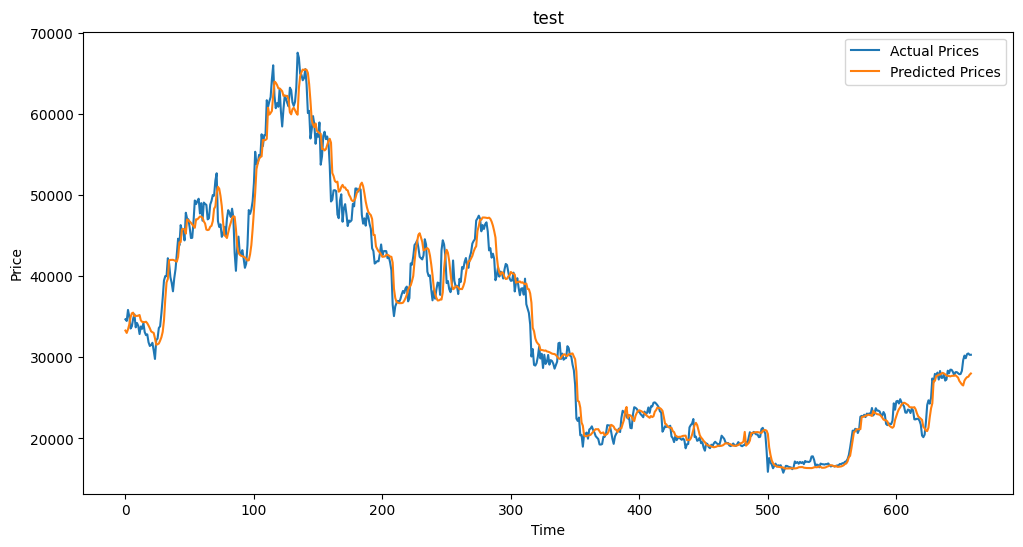

In [105]:
plt.figure(figsize=(12,6))
plt.plot(true_after_inverse, label='Actual Prices')
plt.plot(pred_after_inverse, label='Predicted Prices')

plt.title('test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

true_train = inverse_train_true
prediction_train = inverse_train_pred
prediction_test = pred_after_inverse
true_test = true_after_inverse

def calculate_auc(true_values, predicted_values):
    count = 0
    for i in range(1, len(true_values)):
        if (true_values[i] - true_values[i-1]) * (predicted_values[i] - predicted_values[i-1]) > 0:
            count += 1
    return count / (len(true_values) - 1)

def print_evaluation_results(true_values, predicted_values, dataset_name):
    print("Test accuracy for", dataset_name)
    print("------------------------------------------------------")
    # RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    print("Root Mean Square Error (RMSE): {:.4f}".format(rmse))
    
    # MAPE
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))
    
    # AUC
    auc = calculate_auc(true_values, predicted_values)
    print("AUC test: {:.4f}".format(auc))
    print()

# Print evaluation results for the train set
print_evaluation_results(true_train, prediction_train, "train set")

# Print evaluation results for the test set
print_evaluation_results(true_test, prediction_test, "test set")



Test accuracy for train set
------------------------------------------------------
Root Mean Square Error (RMSE): 284.5720
Mean Absolute Percentage Error (MAPE): 0.0525
AUC test: 0.4605

Test accuracy for test set
------------------------------------------------------
Root Mean Square Error (RMSE): 1824.5343
Mean Absolute Percentage Error (MAPE): 0.0380
AUC test: 0.4848

